In [1]:
import numpy as np
import pandas as pd
import scipy
from plotnine import *
from datetime import datetime
from numpy import sqrt, exp, log, pi, prod

## Andmed

In [2]:
hommik = 21_600 / 60  # hommikune äratus kell 06:00
reservaeg = 60_300 / 60  # reservaja algus kell 16:45
esimene_päev = 197  # teenistuse esimene päev 17.07.2023

In [3]:
spioon_df = pd.read_csv('andmed/spioonid.csv')

spioon_df['kuupäev'] = spioon_df['kuupäev'].apply(lambda x: datetime.fromisoformat(x))
spioon_df['sekund'] = spioon_df['kuupäev'].apply(lambda x: (x - x.replace(hour=0, minute=0, second=0)).total_seconds())
spioon_df['minut'] = spioon_df['sekund'] / 60
spioon_df['päev'] = spioon_df['kuupäev'].apply(lambda x: x.timetuple().tm_yday - esimene_päev)
spioon_df['päev'] = spioon_df.groupby('päev').ngroup()
# spioon_df['päev_n'] = spioon_df.groupby('päev').cumcount()
# spioon_df['tühemik'] = spioon_df.groupby('päev')['sekund'].diff().fillna(spioon_df['sekund'] - hommik)
spioon_df['tegevusaeg'] = (spioon_df['sekund'] >= reservaeg).map({True: 'Vaba- ja reservaeg', False:'Muu aeg'})

spioon_df.tail()

,kuupäev,sekund,minut,päev,tegevusaeg
71,2023-08-24 19:20:26,69626.0,1160.433333,23,Vaba- ja reservaeg
72,2023-08-25 06:48:11,24491.0,408.183333,24,Vaba- ja reservaeg
73,2023-08-25 10:59:16,39556.0,659.266667,24,Vaba- ja reservaeg
74,2023-08-25 14:11:37,51097.0,851.616667,24,Vaba- ja reservaeg
75,2023-08-25 14:46:49,53209.0,886.816667,24,Vaba- ja reservaeg


### Intensiivsuse hinnang

#### Momentide sobitamine
\begin{equation}
    \lambda(t) = \exp{\left\{ \sum_{i = 0}^m \theta_i t^i \right\}}
\end{equation}

$\{ c_j \}$
\begin{equation}
    \sum_{j = 1}^n t_j^i = \sum_{j = 0}^m c_j \frac{T^{i + j + 1}}{i + j + 1} ,
\end{equation}
$i = 0 , 1 , \dots , m$

In [4]:
t = spioon_df[spioon_df['päev'] == 18]['sekund']
T = t.max()
n, = t.shape
m = 1  # polünoomi järk

a = np.array([[pow(T, i + j + 1) / (i + j + 1) for j in range(0, m + 1)] for i in range(0, m + 1)])
b = np.array([sum(pow(t, i)) for i in range(0, m + 1)])
c = np.linalg.solve(a, b)
c = np.maximum(c, np.zeros_like(c))  # !? nii ei tohiks vist !?
c

array([0.00000000e+00, 2.76548758e-09])

$\{ \theta_j \}$
\begin{equation}
    \int_0^T u^i \log \left( \sum_{j = 0}^m c_j u^j \right) du = \sum_{j = 0}^m \frac{\theta_j T^{i + j + 1}}{i + j + 1} ,
\end{equation}
$i = 0 , 1 , \dots , m$

In [5]:
f = lambda u, i: pow(u, i) * log(sum(c * pow(np.repeat(u, m + 1), np.arange(0, m + 1))))
b = np.array([scipy.integrate.quad(f, 0, T, args=(i))[0] for i in range(0, m + 1)])

deeta = np.linalg.solve(a, b)
deeta

array([-1.09540208e+01,  3.89428319e-05])

numbriline optimeerimine

#### Esimest järku polünoom

\begin{equation*}
    \sum_{i = 1}^n \frac{1}{\lambda(t_i | \boldsymbol{\theta})} \ln \frac{\partial}{\partial \boldsymbol{\theta}} \lambda(t_i | \boldsymbol{\theta}) = \frac{\partial}{\partial \boldsymbol{\theta}} \Lambda(0 , T | \boldsymbol{\theta}) .
\end{equation*}

\begin{equation*}
    \frac{\partial \ell(\textbf{t} | n , \theta_1)}{\partial \theta_1} = 
    \begin{cases}
        \frac{n}{\theta_1} + \sum_{i = 1}^n t_i - \frac{n T}{1 - e^{- \theta_1 T}} &, \theta_1 \neq 0 \\
        - \frac{n T}{2} + \sum_{i = 1}^n t_i &, \theta_1 = 0
    \end{cases}
\end{equation*}

\begin{equation*}
    \widehat{\theta}_0 = \log n + \log \widehat{\theta}_1 - \log (e^{\widehat{\theta}_1 T} - 1)
\end{equation*}

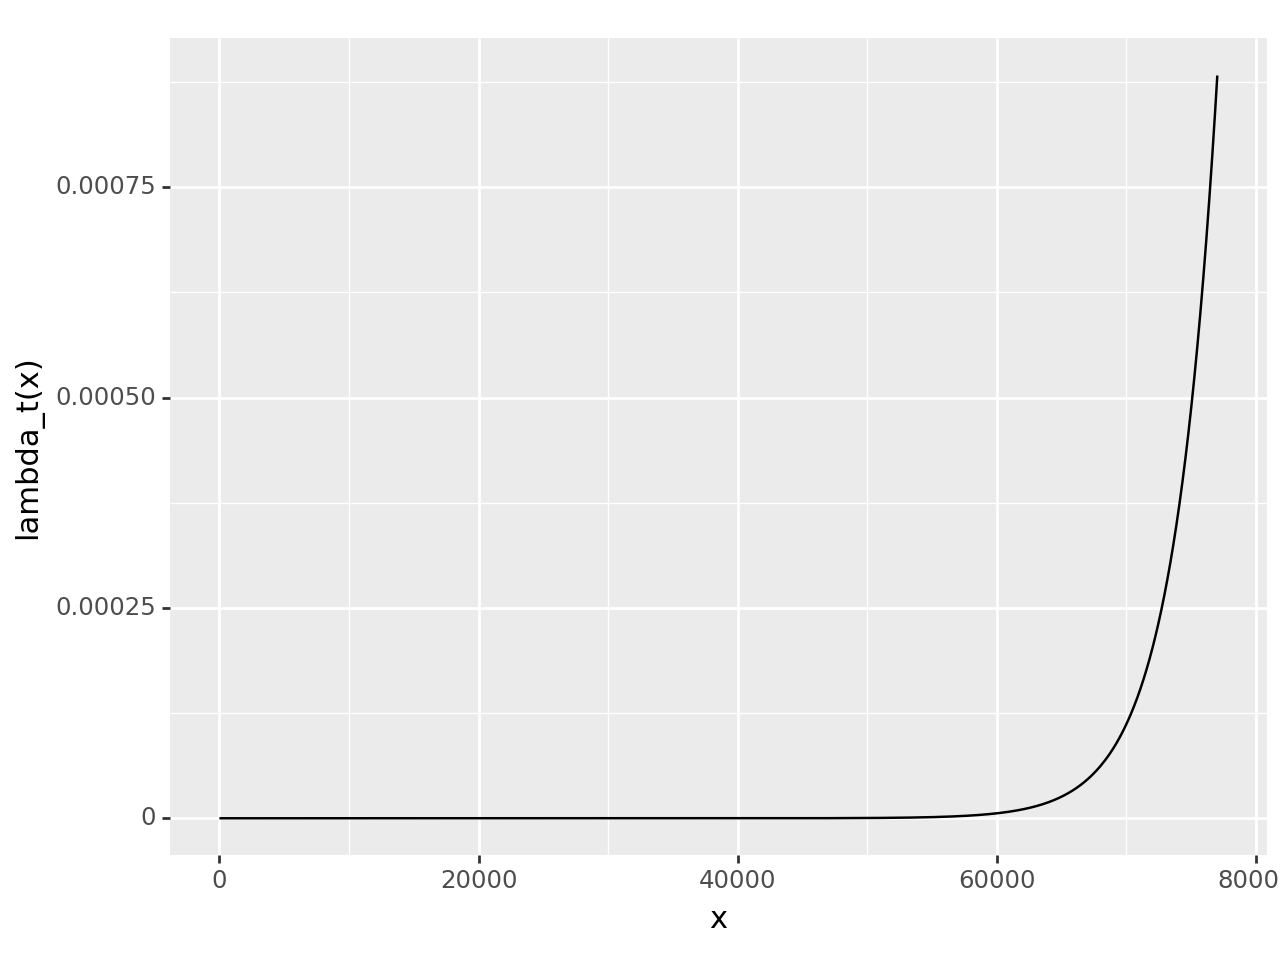

<Figure Size: (640 x 480)>

In [6]:
t = spioon_df[spioon_df['päev'] == 18]['sekund']
f = lambda theta: len(t) / theta + sum(t) - (len(t) * t.max()) / (1 - exp(-theta * t.max()))

theta_1 = scipy.optimize.fsolve(f, 0.001)
theta_0 = log(len(t)) + log(theta_1) - log(exp(theta_1 * t.max()) - 1)
lambda_t= lambda t: np.exp(theta_1 * t + theta_0)

x = np.linspace(0, t.max(), 1000)
ggplot() + geom_line(aes('x', 'lambda_t(x)'))

#### Kaalutud normaaljaotused
\begin{equation}
    \lambda_z(t) = \sum_{k = 1}^K a_{z k} B_k(t) ,
\end{equation}
kus
\begin{align}
    B_k(t) &= \frac{1}{\sigma \sqrt{2 \pi}} \exp \left\{ - \frac{(t - \mu_k)^2}{2 \sigma^2} \right\} , \\
    \mu_k &= \frac{(k - 1) \tau}{K - 1} , \qquad \sigma_k = \frac{\tau}{k} .
\end{align}

In [7]:
def gaussian_base(arrival: float, means: np.array, stds: np.array) -> np.array:
    return exp(- pow(arrival - means, 2) / (2 * pow(stds, 2))) / (stds * sqrt(2 * pi))

def instantenious_arrival_rate(arrival: float, weights: np.array, means: np.array, stds: np.array) -> float:
    return sum(weights * gaussian_base(arrival, means, stds))

def conditional_joint_density(arrivals: np.array, weights: np.array, tau: np.array, means: np.array, stds: np.array) -> float:
    exponenital = exp(-scipy.integrate.quad(instantenious_arrival_rate, 0, tau, args=(weights, means, stds))[0])
    product = prod([instantenious_arrival_rate(arrival, weights, means, stds) for arrival in arrivals])
    return exponenital * product

### Expectation Maximisation
#### Expectation step
Antud parameetrivektori $\theta^r$ korral
\begin{equation}
    p_{iz}^r = \frac{ e^{- \Lambda_z (0 , \tau) } \prod_{j = 1}^n \lambda_z (t_{ij}) }{ \sum_{q = 1}^{Z} e^{- \Lambda_q (0 , \tau)} \prod_{j = 1}^n \lambda_q (t_{ij}) }
\end{equation}

In [16]:
K = 10  # number of gaussian variables
m = spioon_df['päev'].nunique()  # number of event series
Z = m - 10  # number of parent processes

weights = scipy.special.softmax(np.zeros(K * Z).reshape((Z, K)))
mixing_probabilities = scipy.special.softmax(np.zeros(Z))
series_mixing_probabilities = scipy.special.softmax(np.zeros(m * Z).reshape((m, Z)))

k = np.arange(1, K + 1)
tau = spioon_df['minut'].max()
stds = tau / k
means = ((k - 1) * tau) / (K - 1)

In [17]:
groups = spioon_df.groupby('päev')['minut']
for i, arrivals in groups:
    denominator = sum(conditional_joint_density(arrivals, weights[q], tau, means, stds) for q in range(Z))
    for z in range(Z):
        numerator = conditional_joint_density(arrivals, weights[z], tau, means, stds)
        series_mixing_probabilities[i][z] = numerator / denominator

#### Maximisation step
\begin{equation}
    \theta^{r + 1} = \underset{\theta}{\arg \max} \left[ \sum_{i = 1}^m \sum_{z = 1}^Z p_{iz} \ln \left( p_z e^{- \Lambda_z (0 , \tau) } \prod_{j = 1}^n \lambda_z (t_{ij}) \right) \right]
\end{equation}
\begin{equation}
    p_z^{r + 1} = \frac{1}{n} \sum_{i = 1}^m p_{iz}^r
\end{equation}

In [ ]:
def to_maximize(theta: np.array):
    # theta = [mixing_probabilities, ws]
    mix_probs = theta[:Z]
    ws = theta[Z:].reshape(weights.shape)
    
    summ = 0
    
    for i, arrivals in groups:
        for z in range(Z):
            product = series_mixing_probabilities[i][z] 
            product *= log(mix_probs[z] * conditional_joint_density(arrivals, ws[z], tau, means, stds))
            summ += product
    
    return summ

theta = scipy.optimize.minimize(lambda theta: -to_maximize(theta), np.concatenate((mixing_probabilities, weights.flatten())))
mixing_probabilities = theta[:20]
weights = theta[20:].reshape(weights.shape)

theta

C:\Users\martm\AppData\Local\Temp\ipykernel_3608\3524783294.py:11: RuntimeWarning: invalid value encountered in log
C:\Users\martm\AppData\Local\Temp\ipykernel_3608\2478288316.py:8: RuntimeWarning: overflow encountered in exp


In [ ]:
mixing_probabilities = np.mean(series_mixing_probabilities, axis=0)

## Päevakaupa loendavad punktiprotsessid

In [ ]:
g = ggplot(spioon_df) + facet_wrap('tegevusaeg', scales='free_x') + aes('minut', 'päev')
g += theme_linedraw() + theme(panel_spacing=0.05)
g += labs(x='$t$', y='päev')
g += geom_point(shape='x')

# g.save('paber/spioonid_päevakaupa_eraldatud.png', dpi=100)
g

## Astmejoonis

In [ ]:
aste_df = spioon_df.sort_values('minut')
aste_df['n'] = np.arange(0, aste_df.shape[0])

g = ggplot(aste_df) + theme_linedraw() + aes('minut', 'n')
g += labs(x='$t$', y='$N(t)$')
g += geom_vline(xintercept=reservaeg, color='r')
g += geom_step()

# g.save('paber/spioonid_astmejoonis.png', dpi=100)
g